<a href="https://colab.research.google.com/github/MalakAlaa2004/MalakAlaa2004/blob/main/proj_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tarfile
import pandas as pd
import tensorflow as tf
import urllib.request

# Step 1: Download LJSpeech dataset
dataset_url = "https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2"
archive_path = tf.keras.utils.get_file(
    "LJSpeech-1.1.tar.bz2", dataset_url, extract=False
)

# Step 2: Extract into a known directory
extract_path = os.path.join(os.path.expanduser("~"), "ljspeech")
if not os.path.exists(os.path.join(extract_path, "LJSpeech-1.1")):
    os.makedirs(extract_path, exist_ok=True)
    with tarfile.open(archive_path, "r:bz2") as tar:
        tar.extractall(path=extract_path)
    print("✅ Dataset extracted!")
else:
    print("✅ Dataset already extracted.")
# ✅ Set the WAV files path
wavs_path = os.path.join(extract_path, "LJSpeech-1.1", "wavs/")
print("WAV files path:", wavs_path)

# Check if the path exists
if os.path.exists(wavs_path):
    print("WAV files path exists.")
else:
    print("WAV files path does not exist.")

# Step 3: Correct path to metadata.csv
metadata_path = os.path.join(extract_path, "LJSpeech-1.1", "metadata.csv")

# Step 4: Load metadata
metadata_df = pd.read_csv(metadata_path, sep="|", header=None, quoting=3)
metadata_df.columns = ["file_name", "transcription", "normalized_transcription"]
metadata_df = metadata_df[["file_name", "normalized_transcription"]]

# ✅ Get first file name from metadata
first_filename = metadata_df["file_name"].iloc[0]
wav_file_path = os.path.join(wavs_path, first_filename + ".wav")

# Check if the specific WAV file exists
if os.path.exists(wav_file_path):
    print("WAV file exists:", wav_file_path)
else:
    print("WAV file does not exist:", wav_file_path)

# ✅ Check loaded data
print("Loaded metadata shape:", metadata_df.shape)
print(metadata_df.head())

2748572632/2748572632 ━━━━━━━━━━━━━━━━━━━━ 31s 0us/step
✅ Dataset extracted!
WAV files path: /root/ljspeech/LJSpeech-1.1/wavs/
WAV files path exists.
WAV file exists: /root/ljspeech/LJSpeech-1.1/wavs/LJ001-0001.wav
Loaded metadata shape: (13100, 2)
    file_name                           normalized_transcription
0  LJ001-0001  Printing, in the only sense with which we are ...
1  LJ001-0002                     in being comparatively modern.
2  LJ001-0003  For although the Chinese took impressions from...
3  LJ001-0004  produced the block books, which were the immed...
4  LJ001-0005  the invention of movable metal letters in the ...


In [ ]:
import librosa
import numpy as np

def load_wav(file_path, sr=22050):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio

def extract_log_mel_spectrogram(audio, sr=22050, n_mels=80):
    spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    log_mel = librosa.power_to_db(spectrogram)
    return log_mel.T  # Shape: (time, features)

# Extract features from a few examples (you can expand this to the whole dataset)
inputs = []
targets = []

max_len = 1000  # max length in frames
for i, row in metadata_df.head(500).iterrows():
    wav_path = os.path.join(wavs_path, row['file_name'] + ".wav")
    audio = load_wav(wav_path)
    feature = extract_log_mel_spectrogram(audio)

    if feature.shape[0] > max_len:
        feature = feature[:max_len]
    else:
        feature = np.pad(feature, ((0, max_len - feature.shape[0]), (0, 0)), 'constant')

    inputs.append(feature)
    targets.append(row['normalized_transcription'])

inputs = np.array(inputs)
print("Input shape (log-Mel):", inputs.shape)


Input shape (log-Mel): (500, 1000, 80)


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(targets)

sequences = tokenizer.texts_to_sequences(targets)
target_input = pad_sequences(sequences, padding='post')
print("Target input shape:", target_input.shape)

vocab_size = len(tokenizer.word_index) + 1


Target input shape: (500, 169)


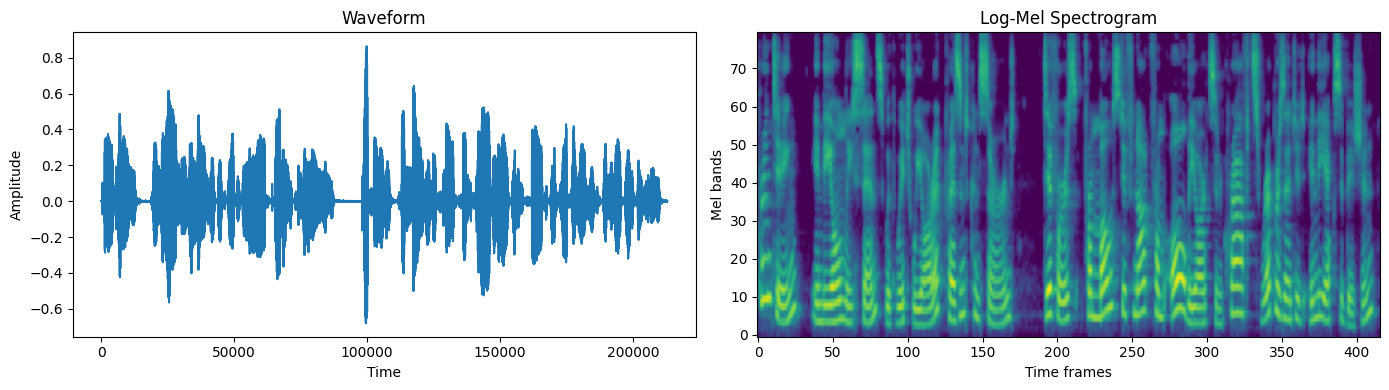

Original Text: Printing, in the only sense with which we are at present concerned, differs from most if not from all the arts and crafts represented in the Exhibition
Token Sequence: [18, 8, 7, 5, 3, 7, 5, 19, 22, 1, 7, 5, 1, 3, 10, 2, 1, 4, 5, 12, 20, 1, 9, 2, 5, 9, 2, 1, 17, 7, 3, 10, 1, 17, 10, 7, 13, 10, 1, 17, 2, 1, 6, 8, 2, 1, 6, 3, 1, 18, 8, 2, 9, 2, 5, 3, 1, 13, 4, 5, 13, 2, 8, 5, 2, 11, 22, 1, 11, 7, 14, 14, 2, 8, 9, 1, 14, 8, 4, 16, 1, 16, 4, 9, 3, 1, 7, 14, 1, 5, 4, 3, 1, 14, 8, 4, 16, 1, 6, 12, 12, 1, 3, 10, 2, 1, 6, 8, 3, 9, 1, 6, 5, 11, 1, 13, 8, 6, 14, 3, 9, 1, 8, 2, 18, 8, 2, 9, 2, 5, 3, 2, 11, 1, 7, 5, 1, 3, 10, 2, 1, 2, 27, 10, 7, 21, 7, 3, 7, 4, 5]


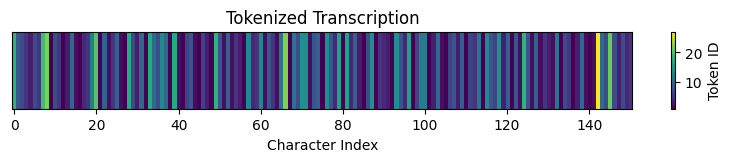

In [ ]:
import matplotlib.pyplot as plt
# Visualize the first audio file
sample_audio = load_wav(wav_file_path)
sample_spec = extract_log_mel_spectrogram(sample_audio)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(sample_audio)
plt.title("Waveform")
plt.xlabel("Time")
plt.ylabel("Amplitude")

plt.subplot(1, 2, 2)
plt.imshow(sample_spec.T, aspect="auto", origin="lower")
plt.title("Log-Mel Spectrogram")
plt.xlabel("Time frames")
plt.ylabel("Mel bands")
plt.tight_layout()
plt.show()
example_text = targets[0]
example_seq = tokenizer.texts_to_sequences([example_text])[0]

print("Original Text:", example_text)
print("Token Sequence:", example_seq)

plt.figure(figsize=(10, 1))
plt.imshow([example_seq], aspect="auto", cmap="viridis")
plt.title("Tokenized Transcription")
plt.yticks([])
plt.xlabel("Character Index")
plt.colorbar(label="Token ID")
plt.show()


In [ ]:
from tensorflow.keras import layers, Model, Input
import tensorflow.keras.backend as K

import tensorflow as tf
from tensorflow.keras import layers
import numpy as np

class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, model_dim):
        super().__init__()
        self.max_len = max_len
        self.model_dim = model_dim

        pos = np.arange(max_len)[:, np.newaxis]
        i = np.arange(model_dim)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(model_dim))
        angle_rads = pos * angle_rates

        # apply sin to even indices and cos to odd indices
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        self.pos_encoding = tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

    def call(self, x):
        seq_len = tf.shape(x)[1]
        return x + self.pos_encoding[:, :seq_len, :]


# Update the transformer_encoder function to accept max_len as a parameter
def transformer_encoder(inputs, num_layers=4, d_model=256, num_heads=4, dff=512, dropout_rate=0.1, max_len=1000):
    x = layers.Dense(d_model)(inputs)
    x = PositionalEncoding(max_len, d_model)(x)  # Use the correct max_len
    for _ in range(num_layers):
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
        x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
        ffn_output = layers.Dense(dff, activation='relu')(x)
        ffn_output = layers.Dense(d_model)(ffn_output)
        x = layers.LayerNormalization(epsilon=1e-6)(x + ffn_output)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Update the build_dual_head_model function to pass max_len
def build_dual_head_model(input_shape, vocab_size, d_model=256):
    inputs = Input(shape=input_shape, name="log_mel_input")

    # Transformer Encoder
    encoder_output = transformer_encoder(inputs, d_model=d_model, max_len=input_shape[0])

    # CTC Head
    ctc_logits = layers.Dense(vocab_size, name="ctc_logits")(encoder_output)

    # Decoder Head
    decoder_inputs = Input(shape=(None,), name="decoder_input")
    decoder_embed = layers.Embedding(vocab_size, d_model)(decoder_inputs)
    decoder_pos = PositionalEncoding(100, d_model)(decoder_embed)
    decoder_output = layers.MultiHeadAttention(num_heads=4, key_dim=d_model)(
        decoder_pos, encoder_output, encoder_output
    )
    decoder_output = layers.LayerNormalization(epsilon=1e-6)(decoder_pos + decoder_output)
    decoder_output = layers.Dense(vocab_size, name="decoder_output")(decoder_output)

    return Model(inputs=[inputs, decoder_inputs], outputs=[ctc_logits, decoder_output])


In [ ]:
# Rebuild the model with the correct input shape
input_shape = (1000, 80)  # Adjust this to match your data
model = build_dual_head_model(input_shape=input_shape, vocab_size=vocab_size)

# Compile the model again
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss={
        "ctc_logits": ctc_loss_fn,
        "decoder_output": seq2seq_loss
    },
    metrics={
        "decoder_output": "accuracy"
    }
)

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ log_mel_input       │ (None, 1000, 80)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_29 (Dense)    │ (None, 1000, 256) │     20,736 │ log_mel_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encodin… │ (None, 1000, 256) │          0 │ dense_29[0][0]    │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1000, 256) │  1,051,904 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_27 (Add)        │ (None, 1000, 256) │          0 │ positional_encod… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1000, 256) │        512 │ add_27[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_30 (Dense)    │ (None, 1000, 512) │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 1000, 256) │    131,328 │ dense_30[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_28 (Add)        │ (None, 1000, 256) │          0 │ layer_normalizat… │
│                     │                   │            │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1000, 256) │        512 │ add_28[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 1000, 256) │          0 │ layer_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 1000, 256) │  1,051,904 │ dropout_28[0][0], │
│ (MultiHeadAttentio… │                   │            │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_29 (Add)        │ (None, 1000, 256) │          0 │ dropout_28[0][0], │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1000, 256) │        512 │ add_29[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 1000, 512) │    131,584 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 1000, 256) │    131,328 │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_30 (Add)        │ (None, 1000, 256) │          0 │ layer_normalizat… │
│                     │                   │            │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1000, 256) │        512 │ add_30[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,106,512 (27.11 MB)

 Trainable params: 7,106,512 (27.11 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# CTC Loss
def ctc_loss_fn(y_true, y_pred):
    label_length = tf.math.count_nonzero(y_true, axis=-1, dtype=tf.int32)
    input_length = tf.fill([tf.shape(y_pred)[0]], tf.shape(y_pred)[1])
    return tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)

# Seq2Seq Loss
seq2seq_loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [ ]:
# Example test data
test_encoder_input = np.random.rand(1, inputs.shape[1], inputs.shape[2]).astype(np.float32)  # Use the same shape as training data
test_decoder_input = np.random.randint(0, vocab_size, size=(1, 10)).astype(np.int32)  # Example decoder input

# Example true labels for testing (dummy data)
true_ctc_labels = np.random.randint(0, vocab_size, size=(1, 20)).astype(np.int32)  # CTC labels
true_decoder_labels = np.random.randint(0, vocab_size, size=(1, 10)).astype(np.int32)  # Decoder labels

In [ ]:
# Make predictions
ctc_logits, decoder_output = model.predict([test_encoder_input, test_decoder_input])

# Print the results
print("CTC Logits:", ctc_logits)
print("Decoder Output:", decoder_output)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
CTC Logits: [[[ 1.1558602  -0.8214933   0.6494983  ... -0.0994997  -0.27498198
    0.5449988 ]
  [ 1.3771397  -0.68836397  0.37714148 ... -0.1959914  -0.11996929
    0.65568006]
  [ 1.7733032  -0.9673936   0.2727514  ...  0.25562835 -0.01081172
    0.45022553]
  ...
  [ 1.5019379  -1.8086694  -0.2771373  ... -0.1956209   0.22607201
    0.61552626]
  [ 1.2959012  -1.3740819  -0.28139162 ...  0.09747042  0.01839336
    0.4120988 ]
  [ 0.9784579  -0.8634681  -0.44667807 ...  0.03278412 -0.5117992
    0.07745461]]]
Decoder Output: [[[ 0.47548577 -0.17823401  0.44596246 ... -0.00816204 -0.5103169
    0.53245604]
  [ 0.45171124 -0.22405997  0.0699591  ... -0.14983085 -0.35235327
    0.80088645]
  [ 0.5131246  -0.18737209  0.04203305 ... -0.09883256 -0.20597647
    1.1153035 ]
  ...
  [ 0.46008742 -0.86901736  0.23151742 ... -0.4103398   0.03317922
    0.13224685]
  [ 0.61767805 -0.96304905  0.14232166 ... -0.3597078  -0.29304224
    0.22943634]
  [ 0.71217

In [ ]:
decoded_ctc, _ = tf.nn.ctc_beam_search_decoder(
    tf.transpose(ctc_logits, [1, 0, 2]),  # Transpose to (time_steps, batch_size, vocab_size)
    sequence_length=[ctc_logits.shape[1]] * ctc_logits.shape[0],
    beam_width=10  # Adjust beam width as needed
)
decoded_ctc = tf.sparse.to_dense(decoded_ctc[0]).numpy()
decoded_ctc_text = ''.join([tokenizer.index_word.get(i, '') for i in decoded_ctc[0]])
print("Decoded CTC Text with Beam Search:", decoded_ctc_text)

Decoded CTC Text with Beam Search: wjjjjjjjjjjjjjjjjjjjjjujjjjwjwjjjjjjjjjjhhhhj


In [ ]:
!pip install jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
from jiwer import wer, cer

def evaluate_ctc(predictions, ground_truths):
    # Convert predictions and ground truths to strings
    pred_texts = [''.join([tokenizer.index_word.get(i, '') for i in pred]) for pred in predictions]
    gt_texts = [''.join([tokenizer.index_word.get(i, '') for i in gt]) for gt in ground_truths]

    # Calculate CER and WER
    cer_score = cer(gt_texts, pred_texts)

    print(f"CER: {cer_score:.2f}")

# Example usage
evaluate_ctc(decoded_ctc, true_ctc_labels)

CER: 45.00
